# Implemention of a Gauss classifier that can distinguish between ten classes of digits

Dataset (ZIP code) taken from:
https://web.stanford.edu/%7Ehastie/ElemStatLearn/data.html

We will compare the logarithm of two normal distributions to avoid an underflow.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.exists("zip.train"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz
  ! gunzip zip.train.gz
    
if not os.path.exists("zip.test"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
  ! gunzip zip.test.gz

In [2]:
def load_from_file(path):
  df = pd.read_csv(path, header=None, sep=" ")
  X = df.iloc[:, 1:257].values # there is an empty string at position 257, because every line ends with a space (== separator)
  y = df.iloc[:, 0].values
  return X, y

# data load

In [3]:
# Training and test data load
X_train, y_train = load_from_file("zip.train")
X_test, y_test = load_from_file("zip.test") 

In [4]:
#shape of training and test set
print("N_train = {}".format(len(X_train)))
print("N_test = {}".format(len(X_test)))

N_train = 7291
N_test = 2007


# Data Visualisation

In [5]:
num_samples = 20
indices = np.random.choice(range(len(X_train)), num_samples)
sample_digits = X_train[indices]
sample_labels = y_train[indices]

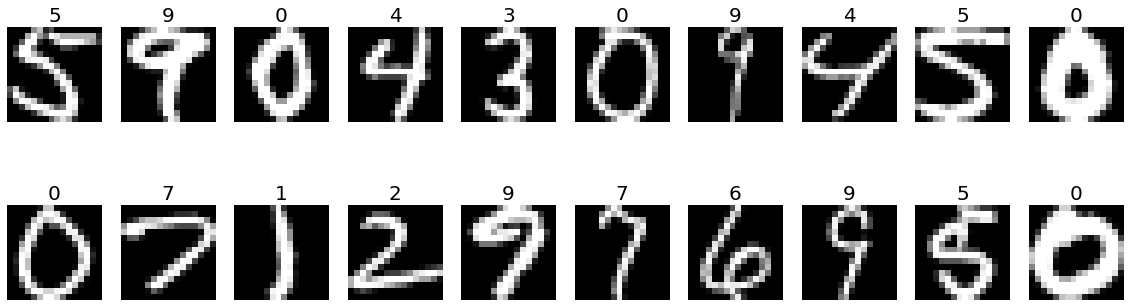

In [6]:
fig = plt.figure(figsize=(20, 6))
for i in range(num_samples):
    ax = plt.subplot(2, 10, i + 1)
    img = sample_digits[i].reshape((16, 16))
    plt.imshow(img, cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')
    plt.title(int(sample_labels[i]), size=20)

In [7]:
class Classifier:
    '''
    general class for prediction score and confusion matrix'''
    
    def score(self, y_prediction, y_test_set):
        return np.mean(y_prediction == y_test_set)
    
    def confusion_matrix(self, y_true, y_predicted):
        size = len(np.unique(y_true)) # or set(y_true)
        conf_matrix = np.zeros((size,size), dtype=np.int32)
        
        for y_label, pred_lable in zip(y_true, y_predicted):
            conf_matrix[int(y_label)][int(pred_lable)] += 1
        
        return conf_matrix

Predict: 

For each class, calculate the probability (using previously calculated average vector / covariance matrix) and then predict the class with highest probability

In [8]:
#separating train set into distinct 10 sets
class_types = np.unique(y_train)
grouped_X = []
for i in range(len(class_types)):
    grouped_X.append(X_train[y_train == i])

In [9]:
def mean(X):
    '''
    mean of each class X in dataset
    parameter: 
        X: nd array of each class
    returns:
        mean : shape (256,)
    '''
    return np.mean(X, axis = 0)

In [10]:
mu1 = mean(grouped_X[0])

In [11]:
def covariance_matrix(X, mu):
    '''
    Covariance of each class X in dataset
    parameter: 
        X: nd array of each class: in grouped_X 
        mu : mean of individual class: in grouped_X 
    returns:
        covariance_matrix : shape (256, 256)
    '''
    num_samples = len(X)
    X_centered = X - mu # mu is subtracted from all rows of X
    cov = X_centered.transpose().dot(X_centered) / num_samples
    return cov

In [89]:
def covariance_matrix_regularised(cov_matrix, alpha):
    '''
    Covariance of each class X in dataset if det(X) == 0
    parameter: 
        cov_matrix: covariance_matrix of a class 
        alpha: parameter for regularisation by running method 
    returns:
        regularised covariance_matrix : shape (256, 256)
    '''
    size = cov_matrix.shape[1]# num of data features 
    cov_reg = np.eye(size) * alpha + (1 - alpha) * cov_matrix
    while np.linalg.det(cov_matrix) == 0:
            cov_matrix = alpha* np.eye(size) + (1-alpha)*cov_matrix
            alpha = alpha + 0.01
    return cov_reg

In [56]:
covariance_matrix(grouped_X[0], mu1).shape

(256, 256)

In [95]:
def log_gaussian_pdf(X, mu, sigma):
    # log probability of a class,
    k = 256 # dimension
    log_normalization_term = -k/2 * np.log(2 * np.pi) - 0.5*np.log(np.linalg.det(sigma))
    exponent = -0.5 * np.sum((X - mu).transpose() * (np.linalg.inv(sigma).dot((X - mu).transpose())), axis=0)
    #c = -0.5 * np.dot((X - mu).T, np.dot(np.linalg.inv(sigma), (X - mu)))
    return log_normalization_term + exponent

In [92]:
def log_gaussian_pdf(X, sigma, mu):
    dim = 256
    log_normalization_term = -dim/2 * np.log(2 * np.pi) - 0.5*np.log(np.linalg.det(sigma))
    
    X_centered = X - mu
    exponent = -0.5 * np.sum((X - mu).transpose() * (np.linalg.inv(sigma).dot((X - mu).transpose())), axis=0)   
    # equivalent to
    # exponent = -0.5 * np.diagonal(X_centered.dot(np.linalg.inv(sigma).dot(X_centered.transpose())))
    
    
    return log_normalization_term + exponent

In [73]:
pred_label_list = np.zeros(shape=(3, 10))

In [74]:
pred_label_list

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [84]:
class Guass_classifier(Classifier):
    
    def fit(self, X, y):
        self.labels = np.unique(y)
        self.means = []
        self.covariances = []
        group_X = []
        for i in range(len(self.labels)):
            group_X.append(X[y == i]) # grouping same label data points
            mu = mean(group_X[-1])
            self.means.append(mu)
            cov = covariance_matrix(group_X[-1], mu)
            if np.linalg.det(cov) == 0.0:
                cov = covariance_matrix_regularised(cov, mu)
            self.covariances.append(cov)        
        
    
    def predict(self, x):
        '''predicts the class for new input with most log probability
        posteriar probability:  p(C|X) = p(X)
        X: test set
        returns 
        '''
        pred_label_list = np.zeros(10)
        for i in range(10):
            print(self.covariances[i].shape)
            pred_label_list[i] = log_gaussian_pdf(x, self.means[i], self.covariances[i])    
        return np.argmax(pred_label_list) 
    
    
    def predict_all(self, X):
        #prediction looping over all data samples
        result = np.zeros(len(X))
        for i in range(len(X)):
            result[i] = self.predict(X[i])
        return result

In [ ]:
#y_pred = clf.predict_all(X_test)
score = np.mean(y_pred == y_test)
print("score: {}".format(score))
cm = clf.confusion_matrix(y_test, y_pred)
print("confusion matrix: (rows=y_true columns=y_predicted)")
labels = range(10)
print(pd.DataFrame(cm, index=labels, columns=labels))

In [96]:
clf = Guass_classifier()
clf.fit(X_train, y_train)
pred_label_list = np.zeros(10)
for i in range(10):
    pred_label_list[i] = log_gaussian_pdf(X_test[0], clf.means[i], clf.covariances[i])    
    vv = np.argmax(pred_label_list)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
